In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols


In [2]:
# Step 2: Simulate RNA-seq count data
np.random.seed(42)
genes = [f"Gene_{i}" for i in range(1, 101)] # 100 genes
samples = [f"Sample_{i}" for i in range(1, 11)] # 10 samples


In [3]:
# Simulate count data: 5 control + 5 treatment
counts = pd.DataFrame(
np.random.poisson(lam=[20]*5 + [50]*5, size=(100, 10)),
index=genes,
columns=samples
)

In [4]:
# Step 3: Metadata (experimental design)
metadata = pd.DataFrame({
"sample": samples,
"condition": ["Control"]*5 + ["Treatment"]*5
})
metadata.set_index("sample", inplace=True)
print("\nMetadata Preview:")
print(metadata.head())
print("\nCounts Preview:")
print(counts.iloc[:5, :5])


Metadata Preview:
         condition
sample            
Sample_1   Control
Sample_2   Control
Sample_3   Control
Sample_4   Control
Sample_5   Control

Counts Preview:
        Sample_1  Sample_2  Sample_3  Sample_4  Sample_5
Gene_1        23        15        21        25        15
Gene_2        16        21        21        17        22
Gene_3        21        13        18        25        17
Gene_4        26        18        17        23        26
Gene_5        27        19        16        17        28


In [5]:
# Step 4: Normalize counts (log2 transformation)
log_counts = np.log2(counts + 1)


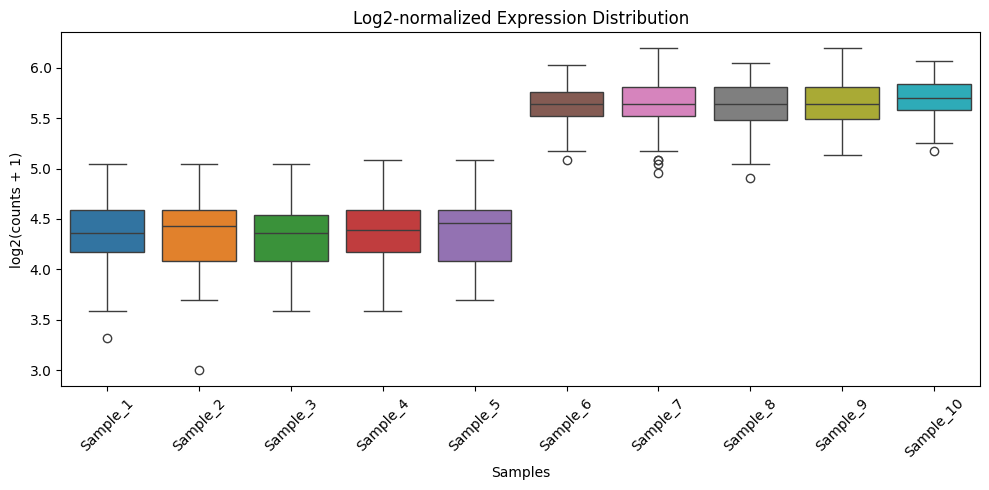

In [6]:
# Step 5: Exploratory Data Analysis
plt.figure(figsize=(10, 5))
sns.boxplot(data=log_counts)
plt.title("Log2-normalized Expression Distribution")
plt.xlabel("Samples")
plt.ylabel("log2(counts + 1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Interpretation of the Boxplot (Step 5):**

*   The boxplot shows the distribution of log2-normalized gene expression values for each sample.
*   Each box represents a sample, and the box spans the interquartile range (IQR), from the 25th to the 75th percentile of expression values for that sample.
*   The line inside the box indicates the median expression level for each sample.
*   The "whiskers" extending from the box show the range of the data, typically up to 1.5 times the IQR from the box edges. Data points outside the whiskers are considered outliers and are plotted individually.
*   By visually comparing the boxes, we can assess the overall distribution and variability of gene expression across samples.
*   In this specific boxplot, we can see that the median expression levels are generally higher in the "Treatment" samples (Sample_6 to Sample_10) compared to the "Control" samples (Sample_1 to Sample_5).
*   This suggests a potential difference in gene expression between the control and treatment groups, which aligns with how the data was simulated (higher lambda for treatment samples).
*   The spread of the boxes (IQR) and the length of the whiskers give an idea of the variability within each sample.
*   Outliers, if present, could indicate genes with unusually high or low expression in specific samples.
*   Overall, this boxplot provides a quick visual summary of the data distribution and highlights potential differences between the experimental groups, which is a crucial step in exploratory data analysis before performing more formal differential expression analysis.

In [9]:
# Step 6: Compute mean expression by condition
condition_labels = metadata["condition"].values
control_mean = log_counts.iloc[:, :5].mean(axis=1)
treat_mean = log_counts.iloc[:, 5:].mean(axis=1)
diff_expr = pd.DataFrame({
"gene": genes,
"control_mean": control_mean,
"treat_mean": treat_mean,
})
diff_expr["log2FoldChange"] = diff_expr["treat_mean"] - diff_expr["control_mean"]
display(diff_expr.head())

,gene,control_mean,treat_mean,log2FoldChange
Gene_1,Gene_1,4.348967,5.618757,1.269790
Gene_2,Gene_2,4.339963,5.631702,1.291739
Gene_3,Gene_3,4.277016,5.684884,1.407868
Gene_4,Gene_4,4.502518,5.650069,1.147551
Gene_5,Gene_5,4.448930,5.718010,1.269079


In [11]:
# Step 7: Simple statistical test (OLS model)
p_values = []
for gene in genes:
    expr = log_counts.loc[gene]
    data = pd.DataFrame({"expr": expr, "condition": condition_labels})
    model = ols("expr ~ C(condition)", data=data).fit()
    p_values.append(model.pvalues["C(condition)[T.Treatment]"])
diff_expr["p_value"] = p_values
diff_expr["-log10(p_value)"] = -np.log10(diff_expr["p_value"])
display(diff_expr.head())

,gene,control_mean,treat_mean,log2FoldChange,p_value,-log10(p_value)
Gene_1,Gene_1,4.348967,5.618757,1.269790,0.000032,4.498241
Gene_2,Gene_2,4.339963,5.631702,1.291739,0.000017,4.759199
Gene_3,Gene_3,4.277016,5.684884,1.407868,0.000038,4.425012
Gene_4,Gene_4,4.502518,5.650069,1.147551,0.000071,4.148190
Gene_5,Gene_5,4.448930,5.718010,1.269079,0.000117,3.932005


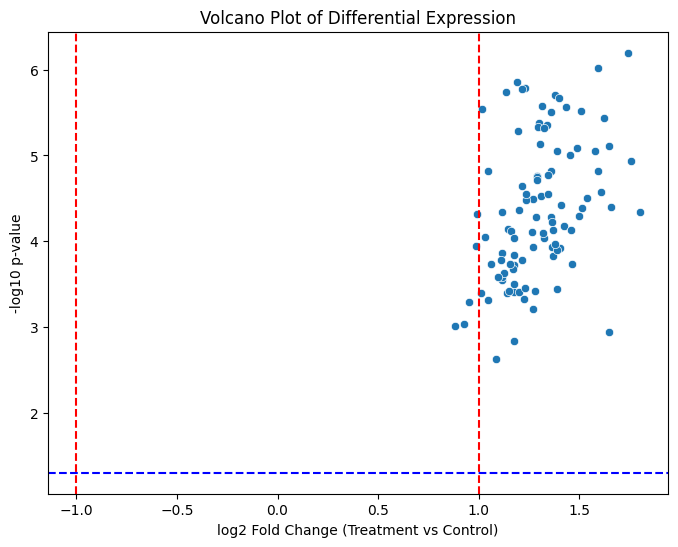

In [12]:
# Step 8: Volcano plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=diff_expr, x="log2FoldChange", y="-log10(p_value)")
plt.axvline(1, color="red", linestyle="--")
plt.axvline(-1, color="red", linestyle="--")
plt.axhline(1.3, color="blue", linestyle="--") # ~ p=0.05
plt.title("Volcano Plot of Differential Expression")
plt.xlabel("log2 Fold Change (Treatment vs Control)")
plt.ylabel("-log10 p-value")
plt.show()


**Interpretation of the Volcano Plot (Step 8):**

*   The volcano plot is a scatter plot that visualizes the results of differential expression analysis.
*   Each point on the plot represents a gene.
*   The x-axis represents the log2 fold change (log2FC) in gene expression between the two conditions (Treatment vs Control). Positive log2FC values indicate genes that are upregulated in the treatment group, while negative log2FC values indicate genes that are downregulated.
*   The y-axis represents the negative logarithm (base 10) of the p-value (-log10 p-value). Higher values on the y-axis correspond to smaller p-values and thus greater statistical significance.
*   The dashed vertical lines are typically drawn at a specified log2FC threshold (e.g., log2FC = 1 and log2FC = -1), representing a fold change of 2 in either direction. Genes outside these lines are considered to have a substantial fold change.
*   The dashed horizontal line is typically drawn at a specified p-value threshold (e.g., -log10(0.05) ≈ 1.3), representing a common significance level. Genes above this line are considered statistically significant.
*   Genes that are both statistically significant (above the horizontal line) and have a substantial fold change (outside the vertical lines) are often considered potential differentially expressed genes. These genes are typically located in the upper left and upper right quadrants of the plot.
*   In this specific volcano plot, we can observe a cluster of points in the upper right quadrant, indicating genes that are upregulated in the treatment group and are statistically significant. This aligns with the simulated data where the treatment group had a higher lambda for count generation.
*   There are also points in the upper left quadrant, indicating genes that are downregulated in the treatment group and are statistically significant.
*   Points below the horizontal line are not considered statistically significant at the chosen p-value threshold, regardless of their fold change.
*   Points between the vertical lines are considered to have a small fold change, regardless of their statistical significance.
*   The volcano plot provides a visual summary of the differential expression results, allowing for quick identification of genes that are both statistically significant and have a meaningful change in expression.

In [13]:
# Step 9: Identify significantly differentially expressed genes
sig_genes = diff_expr[(abs(diff_expr["log2FoldChange"]) > 1) &
(diff_expr["p_value"] < 0.05)]
print("\nSignificant Differentially Expressed Genes:")
print(sig_genes.head())


Significant Differentially Expressed Genes:
          gene  control_mean  treat_mean  log2FoldChange   p_value  \
Gene_1  Gene_1      4.348967    5.618757        1.269790  0.000032   
Gene_2  Gene_2      4.339963    5.631702        1.291739  0.000017   
Gene_3  Gene_3      4.277016    5.684884        1.407868  0.000038   
Gene_4  Gene_4      4.502518    5.650069        1.147551  0.000071   
Gene_5  Gene_5      4.448930    5.718010        1.269079  0.000117   

        -log10(p_value)  
Gene_1         4.498241  
Gene_2         4.759199  
Gene_3         4.425012  
Gene_4         4.148190  
Gene_5         3.932005  


In [17]:
import plotly.express as px

fig = px.scatter(diff_expr,
                 x="log2FoldChange",
                 y="-log10(p_value)",
                 hover_name="gene",
                 title="Interactive Volcano Plot of Differential Expression")

fig.add_vline(x=1, line_dash="dash", line_color="red")
fig.add_vline(x=-1, line_dash="dash", line_color="red")
fig.add_hline(y=1.3, line_dash="dash", line_color="blue") # ~ p=0.05

fig.show()

**Interpretation of the Interactive Volcano Plot (Cell 17):**

*   The interactive volcano plot is a scatter plot that visualizes the results of differential expression analysis, allowing for hovering to see gene names.
*   Each point on the plot represents a gene.
*   The x-axis represents the log2 fold change (log2FC) in gene expression between the two conditions (Treatment vs Control). Positive log2FC values indicate genes that are upregulated in the treatment group, while negative log2FC values indicate genes that are downregulated.
*   The y-axis represents the negative logarithm (base 10) of the p-value (-log10 p-value). Higher values on the y-axis correspond to smaller p-values and thus greater statistical significance.
*   The dashed vertical lines are typically drawn at a specified log2FC threshold (e.g., log2FC = 1 and log2FC = -1), representing a fold change of 2 in either direction. Genes outside these lines are considered to have a substantial fold change.
*   The dashed horizontal line is typically drawn at a specified p-value threshold (e.g., -log10(0.05) ≈ 1.3), representing a common significance level. Genes above this line are considered statistically significant.
*   Genes that are both statistically significant (above the horizontal line) and have a substantial fold change (outside the vertical lines) are often considered potential differentially expressed genes. These genes are typically located in the upper left and upper right quadrants of the plot.
*   In this specific interactive volcano plot, hovering over the points reveals the gene names, which is helpful for identifying specific genes of interest.
*   We can observe a cluster of points in the upper right quadrant, indicating genes that are upregulated in the treatment group and are statistically significant. This aligns with the simulated data where the treatment group had a higher lambda for count generation.
*   There are also points in the upper left quadrant, indicating genes that are downregulated in the treatment group and are statistically significant.
*   Points below the horizontal line are not considered statistically significant at the chosen p-value threshold, regardless of their fold change.
*   Points between the vertical lines are considered to have a small fold change, regardless of their statistical significance.
*   The interactive nature of the plot allows for zooming and panning, making it easier to explore the data and identify individual genes.
*   Overall, this interactive volcano plot provides a visual summary of the differential expression results with added functionality for exploring individual gene data.

**Summary of the RNA-Seq Differential Expression Analysis:**

Here is a summary of the steps we performed in this notebook:

*   **Step 1: Import libraries:** We imported the necessary Python libraries for data manipulation, statistical analysis, and visualization (pandas, numpy, seaborn, matplotlib, statsmodels).
*   **Step 2: Simulate RNA-seq count data:** We simulated RNA-seq count data for 100 genes across 10 samples, divided into 5 control and 5 treatment samples, using a Poisson distribution with different lambda values to simulate differential expression.
*   **Step 3: Metadata (experimental design):** We created a metadata DataFrame to store information about the experimental design, specifically the condition (Control or Treatment) for each sample.
*   **Step 4: Normalize counts (log2 transformation):** We applied a log2 transformation to the raw count data after adding a small value (+1) to handle zero counts, which is a common normalization step for RNA-seq data.
*   **Step 5: Exploratory Data Analysis:** We generated a boxplot of the log2-normalized expression data to visually inspect the distribution of expression values across samples and identify potential differences between the control and treatment groups.
*   **Step 6: Compute mean expression by condition:** We calculated the mean log2-normalized expression for each gene in both the control and treatment groups and computed the log2 fold change (log2FC) between the two conditions.
*   **Step 7: Simple statistical test (OLS model):** We performed a simple statistical test using an Ordinary Least Squares (OLS) model for each gene to assess the statistical significance of the observed fold change and obtained p-values.
*   **Step 8: Volcano plot:** We generated a volcano plot to visualize the results of the differential expression analysis, showing the relationship between log2FC and statistical significance (-log10 p-value).
*   **Step 9: Identify significantly differentially expressed genes:** We identified genes that met specific criteria for both log2FC and p-value thresholds, considering them as significantly differentially expressed genes.
*   **Step 10: Interactive Volcano Plot:** We generated an interactive volcano plot using Plotly to visualize the differential expression results with hover functionality for gene names.
*   **Step 11: Save results:** Finally, we saved the complete differential expression results (including log2FC, p-values, etc.) to a CSV file for further analysis or sharing.